남자 봄 코디 콘텐츠가 어떤 주제로 나뉘었는지 알아보자.

- 추출 채널 : 네이버 블로그
- 기간 : 2020.3.1 ~ 2020.3.13

## 1.데이터

### 1)데이터 로드

In [1]:
# 기본
import pandas as pd
import numpy as np
import re, warnings, time

# 형태소
from collections import Counter
from khaiii import KhaiiiApi

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# 시각화
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim as gensimvis
%matplotlib inline

warnings.filterwarnings('ignore')

# 파일 로드
data = pd.read_csv('/home/lab543/jupyter/jinyoung/data/men_spring_cody.csv')
data = data[['keyword','date','title','content','username','site','link']]


# 데이터 확인
print(len(data))
data.head()

2823


,keyword,date,title,content,username,site,link
0,남자 봄 코디,2020-03-01,20대가방브랜드 뭐가 좋으세요? 여성크로스백추천 스트레치엔젤스 파니니백 예뻐요,20대가방브랜드 뭐가 좋으세요? 여성크로스백추천 스트레치엔젤스 파니니백 예뻐요 이...,티파니,naverBlog,https://m.blog.naver.com/glassgirlsh?Redirect=...
1,남자 봄 코디,2020-03-01,다가오는 봄을 신진 디자이너 브랜드 INSIK 발마칸 코트로 준비,안녕하세요! J입니다!오늘 리뷰할 아이템은 INSIK이라는 국내 브랜드 디자이너의 ...,jsun,naverBlog,https://m.blog.naver.com/whftjs?Redirect=Log&l...
2,남자 봄 코디,2020-03-01,플레이키즈 프로 간절기 스타일링 나이키 바람막이 + 레깅스 코디,플레이키즈 프로 간절기 스타일링 나이키 바람막이 +레깅스 코디플레이키즈 프로 간절기...,뷰스타 니모와민구리,naverBlog,https://m.blog.naver.com/nimoforever?Redirect=...
3,남자 봄 코디,2020-03-01,화이트데이 선물 다니엘 웰링턴 시계 볼수록 기분좋아! 할인코드,​#화이트데이선물 #다니엘웰링턴 #다니엘웰링턴시계​​​​잇님들~ MareN이예요ㅎㅎ...,Mare N,naverBlog,https://m.blog.naver.com/knw1124?Redirect=Log&...
4,남자 봄 코디,2020-03-01,왜냐면 우리는 우리를 모르고,​​​​​​​여름에 이 머리를 해볼까 생각(만 하는) 중​​​​​​​이 바드드득 갈...,견,naverBlog,https://m.blog.naver.com/rbdnjs129/221832729683


### 2)데이터 탐색

In [2]:
# 결측치
data.isnull().sum()

keyword     0
date        0
title       4
content     0
username    0
site        0
link        0
dtype: int64

- 제목이에 결측치가 존재
- 콘텐츠 내용이 있기 때문에 삭제보다는 빈칸으로 대체

In [3]:
data['title'].fillna('', inplace = True)
data.isnull().sum()

keyword     0
date        0
title       0
content     0
username    0
site        0
link        0
dtype: int64

## 2.전처리

### 1)url, e-mail

In [4]:
text_data = data['title']+data['content']

all_url = "[a-zA-Z0-9./?=&-_$%^?&!\"\'#@,><]{1,}[.][a-zA-Z0-9./?=&-_$%^?&!\"\'#@,><]{1,}"
url = "(https?://)?(www.)?[a-zA-Z0-9./?=&-_]+[.]?[/][a-zA-Z0-9./?=&-_%]+" #한글이 들어간 경우도 있기 때문
email = "[-_.+a-zA-Z0-9]+[@].+[.][[a-zA-Z0-9]+|[a-zA-Z0-9]+[.][a-zA-Z0-9]+]"

for i in range(len(text_data)):
    text_data[i] = re.sub(all_url,"", str(text_data[i]))
    text_data[i] = re.sub(url,"", text_data[i])
    text_data[i] = re.sub(email,"", text_data[i])
    text_data[i] = text_data[i].lower()

- 텍스트 컬럼만 분석한다.
- 정규표현식을 이용하여 텍스트 안에 url이나 이메일을 지운다.
- 영어는 소문자로 통일해준다.

### 2)형태소 나누기

In [5]:
noun ='[가-힣a-zA-Z]{2,}(?=\/NNG)|[가-힣a-zA-Z]{2,}(?=\/NNP)'
forign = '[a-zA-Z]{2,}(?=\/SL)'
adjective = '[가-힣a-zA-Z]{2,}(?=\/VA)'
verb = '[가-힣a-zA-Z]{2,}(?=\/VV)'
n = re.compile(noun+'|'+forign+'|'+adjective+'|'+verb)

start = time.time()

word = list()
document = list()

for i in range(len(text_data)):
    word = list()
    for text in KhaiiiApi().analyze(text_data[i]):
        temp = str(text).split("\t")[1].split('+')
        word.extend(n.findall(str(temp)))
    document.append(word)

print("time:",time.time() - start)

time: 130.7497272491455


- khaiii를 이용하여 형태소로 나눈다.
- 필요한 품사만 가져온다.

### 4)불용단어 제거

## 3.N-gram

### 1)n-gram 모델링

In [6]:
bigram = gensim.models.Phrases(document, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[document], threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### 5)n-gram 적용

In [7]:
bigram_doc = [bigram_mod[nouns] for nouns in document]
bigram_doc[0][:20]

['가방브_랜드',
 '여성크로_스백추',
 '스트레치_엔젤스',
 '파니니백',
 '예쁘',
 '가방브_랜드',
 '여성크로_스백추',
 '스트레치_엔젤스',
 '파니니백',
 '예쁘',
 '온도',
 '오르',
 '어제',
 '외출',
 '겉옷',
 '개인',
 '사계절',
 '좋아하',
 '가슴',
 '감추']

### 6)코퍼스 생성

In [8]:
id2word = corpora.Dictionary(bigram_doc)
corpus = [id2word.doc2bow(doc) for doc in bigram_doc]
corpus[1][:10]

[(3, 1),
 (4, 2),
 (12, 1),
 (15, 5),
 (33, 1),
 (37, 1),
 (60, 1),
 (65, 2),
 (73, 4),
 (88, 3)]

### 7)최적 모델수 찾기

In [9]:
coherence_score = []
for i in range(2,10):
    model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics=i, passes=30, iterations=200)
    coherence_model = CoherenceModel(model, texts = bigram_doc, dictionary = id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('n=',i,"Score: ",coherence_lda)
    coherence_score.append(coherence_lda)

n= 2 Score:  0.47973070186053807
n= 3 Score:  0.45140643939932995
n= 4 Score:  0.513957834342621
n= 5 Score:  0.49508200391739454
n= 6 Score:  0.518322496942599
n= 7 Score:  0.5149376436429457
n= 8 Score:  0.5259816573248823
n= 9 Score:  0.5033829490340902


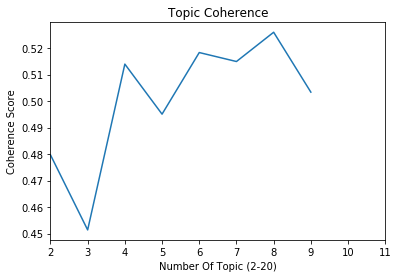

In [10]:
k = []

for i in range(2,10):
    k.append(i)

x = np.array(k)
y = np.array(coherence_score)
plt.title('Topic Coherence')
plt.plot(x,y)
plt.xlim(2,11)
plt.xlabel('Number Of Topic (2-20)')
plt.ylabel('Coherence Score')
plt.show()

### 8)토픽보기

In [11]:
new_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word=id2word, num_topics=4, passes=30, iterations=200)
new_model.print_topics(0)

[(3,
  '0.025*"상품" + 0.013*"구매" + 0.010*"구입" + 0.010*"추천" + 0.009*"선물" + 0.008*"설명" + 0.008*"후기" + 0.007*"제품" + 0.006*"가격" + 0.006*"판매"'),
 (0,
  '0.011*"코디" + 0.010*"남자" + 0.008*"컬러" + 0.008*"제품" + 0.008*"느낌" + 0.007*"착용" + 0.006*"사이즈" + 0.006*"예쁘" + 0.006*"아이템" + 0.005*"보이"'),
 (1,
  '0.024*"상품" + 0.011*"무료_배송" + 0.011*"가격" + 0.009*"추천" + 0.007*"구매" + 0.007*"제품" + 0.006*"클릭" + 0.005*"정보" + 0.005*"남성" + 0.005*"할인"'),
 (2,
  '0.044*"제품" + 0.038*"상세" + 0.023*"남자" + 0.022*"자켓" + 0.020*"남성" + 0.018*"가격" + 0.013*"팬츠" + 0.012*"코트" + 0.011*"추천" + 0.011*"조거"')]

### 9)모델 난이도와 일관성 점수 계산

In [12]:
cm = CoherenceModel(model=new_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', model.log_perplexity(corpus))

Cpherence -1.4691807560594188

Perplexity:  -8.570921500657418


**Coherence** <br>
: coherence는 주제의 일관성을 측정합니다. 해당 토픽모델이, 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 마련입니다. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

- 토픽이 얼마나 의미론적으로 일관성 있는지.
- 높을수록 의미론적 일관성 높음
- 해당 모델이 얼마나 실제로 의미있는 결과를 내는지 확인하기 위해 사용
- 평가를 진행하기 위해 다른 외부 데이터(코퍼스, 시소러스 등)가 필요

**Perplexity** <br>
: perpelxity는 사전적으로는 혼란도 라고 쓰인다고 합니다. 즉 특정 확률 모델이 실제도 관측되는 값을 어마나 잘 예측하는지를 뜻합니다. Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 알 수 있습니다. 따라서 작아지는것이 중요합니다.

- 의미 의미확률 모델이 결과를 얼마나 정확하게 예측하는지.낮을수록 정확하게 예측.
- 토픽 모델링 기법이 얼마나 빠르게 수렴하는지 확인할 때,
- 확률 모델이 다른 모델에 비해 얼마나 개선되었는지 평가할 때,
- 동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용
- 한계 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님

# 4.시각화

In [13]:
prepared_data = gensimvis.prepare(new_model, corpus, id2word)
pyLDAvis.display(prepared_data)